# Modèles Support Vector Machine (SVM) pour classification défaut de crédit

Ce notebook implémente les trois types de SVM pour la classification
1. **C-Support Vector Classification (C-SVC)** - SVM standard avec le paramètre C
3. **Linear SVM** - SVM Linéaire
4. **Non-linear SVM** - SVM avec l'astuce kernel (RBF kernel)
Each model will be trained, evaluated, and compared.

# Contexte
1. Le dataset étudié est déséquilibré où 88% de variable cible et de classe 0 l'autre est de classe 1 où notre intérêt réside.
2. Dans un premier temps on va travailler uniquement avec les modèles SVM sans technique pour addresser le problème de déséquilibre de dataset

# Librairies imports

In [31]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# SVM models
from sklearn.svm import SVC
import time
from imblearn.over_sampling import SMOTE

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Utilities
import time
from imblearn.under_sampling import RandomUnderSampler
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
import joblib
import os
# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Chargement de données

In [32]:
# Load the standardized dataset
data = pd.read_csv(r"C:\5thyear\Data_Mining\Prediction-of-Payment-Default-Using-Ensemble-Methods\Data\data_standardized.csv", index_col=0)

print("Dataset Shape:", data.shape)
print("\n" + "="*50)
print("First few rows:")
print(data.head())
print("\n" + "="*50)
print("Dataset Info:")
print(data.info())

Dataset Shape: (255347, 9)

First few rows:
        Age    Income  LoanAmount  MonthsEmployed  InterestRate  Risk_Score  \
0  0.833990  0.089693   -1.086833        0.590533      0.261771   -0.205494   
1  1.701221 -0.823021   -0.044309       -1.285731     -1.308350   -0.072441   
2  0.166888  0.043854    0.022715       -0.968209      1.156831    0.127186   
3 -0.767053 -1.303452   -1.168538       -1.718715     -0.967805    2.604539   
4  1.100830 -1.592855   -1.671921       -1.487790     -1.052188    0.222707   

   Affordability_Index  Employment_Maturity  Default  
0             0.360521             0.789675        0  
1            -0.454419            -0.420416        0  
2            -0.386242            -0.301056        1  
3            -0.492552            -6.157480        0  
4            -0.380341            -1.054394        0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, 0 to 255346
Data columns (total 9 columns):
 #   Column               Non-N

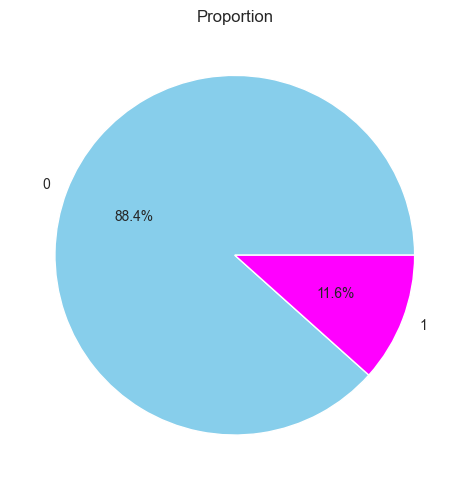

In [19]:
plt.figure(figsize=(5, 5))
data['Default'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                    colors=['skyblue', 'magenta'])
plt.title('Proportion')
plt.ylabel('')  # Remove the ylabel for cleaner appearance
plt.tight_layout()
plt.show()

# Techniques de rééquilibre utilisé:
1. sans technique
2. Ajustement du poids de la classe
3. SMOTE

# Split data and prepare for training

In [33]:
# Separate features and target variable
X = data.drop('Default', axis=1)
y = data['Default']

# Ensure proper data types to avoid attribute errors
X = X.astype('float64')
y = y.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train.head()

,Age,Income,LoanAmount,MonthsEmployed,InterestRate,Risk_Score,Affordability_Index,Employment_Maturity
15826,0.100178,-1.166758,1.698704,-1.170269,-1.336980,-0.207245,-0.474746,-0.578116
147371,0.300309,1.320837,-0.865378,1.716292,0.184923,-0.265957,1.016315,0.990381
178180,0.233598,0.454398,-1.702582,1.398770,-1.202872,-0.311709,9.250079,0.892858
126915,-0.099952,-1.191422,-1.434388,-1.660984,0.722863,2.993000,-0.475121,-2.486541
163930,-1.567575,0.435406,1.707752,0.417340,0.897655,-0.275093,-0.306795,-0.125139


## Model 1: SVM non linéaire Kernal astuce


In [36]:
# --- SVM: FAST VERSION with Nystroem Approximation ---
print("Training Fast SVM (Nystroem RBF Approximation + Calibration)...")
start_time = time.time()


# Create directory if needed

# Model: Nystroem RBF approximation
base_svm = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', gamma=2.0, n_components=100, random_state=42)),
    ('sgd', SGDClassifier(loss='hinge', random_state=42, max_iter=1000))
])
c_svc = CalibratedClassifierCV(base_svm, method='sigmoid', cv=3)

# Fit
c_svc.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"SVM trained in {training_time:.2f} seconds")


Training Fast SVM (Nystroem RBF Approximation + Calibration)...
SVM trained in 3.36 seconds
SVM trained in 3.36 seconds


In [37]:
y_pred = c_svc.predict(X_test)
y_prob = c_svc.predict_proba(X_test)[:, 1]

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred.shape}")
print(f"Probability range: [{y_prob.min():.4f}, {y_prob.max():.4f}]")

Test predictions shape: (51070,)
Probability range: [0.0008, 0.4360]



 EVALUATION RESULTS: C support vector machine

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070


ROC-AUC Score       : 0.6983
PR-AUC (Avg Precision) : 0.2380
Class 1 F1-Score    : 0.0000
Class 1 Recall      : 0.0000
Class 1 Precision   : 0.0000

Confusion Matrix:
[[45139     0]
 [ 5931     0]]


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

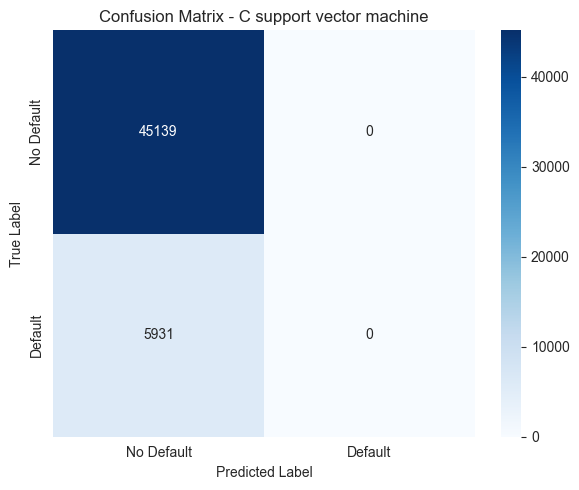

In [38]:
def evaluate_model_final(y_true, y_pred, y_prob, model_name):
    print("\n" + "="*60)
    print(f" EVALUATION RESULTS: {model_name}")
    print("="*60)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    print(classification_report(y_true, y_pred, digits=4))

    # Key Metrics
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    print(f"\nROC-AUC Score       : {roc_auc:.4f}")
    print(f"PR-AUC (Avg Precision) : {pr_auc:.4f}")

    # Extract F1 for class 1
    f1_class1 = report['1']['f1-score']
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']
    print(f"Class 1 F1-Score    : {f1_class1:.4f}")
    print(f"Class 1 Recall      : {recall_class1:.4f}")
    print(f"Class 1 Precision   : {precision_class1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
#evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred,
    y_prob=y_prob,
    model_name="C support vector machine"
)

# Modèle 2 : Linear SVM (Linear Kernel)

In [39]:
start_time = time.time()

# Use LinearSVC with Calibration for faster training
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_linear_svm = LinearSVC(C=1.0, random_state=42, max_iter=2000, dual='auto')
linear_svm = CalibratedClassifierCV(base_linear_svm, method='sigmoid', cv=3)

# Fit the model
linear_svm.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds!")


✓ Training completed in 0.63 seconds!


Test predictions shape: (51070,)
Probability range: [0.0050, 0.6890]

 EVALUATION RESULTS: Linear Kernel

Classification Report:
              precision    recall  f1-score   support

           0     0.8855    0.9982    0.9385     45139
           1     0.5707    0.0177    0.0343      5931

    accuracy                         0.8844     51070
   macro avg     0.7281    0.5080    0.4864     51070
weighted avg     0.8489    0.8844    0.8335     51070


ROC-AUC Score       : 0.7389
PR-AUC (Avg Precision) : 0.2902
Class 1 F1-Score    : 0.0343
Class 1 Recall      : 0.0177
Class 1 Precision   : 0.5707

Confusion Matrix:
[[45060    79]
 [ 5826   105]]


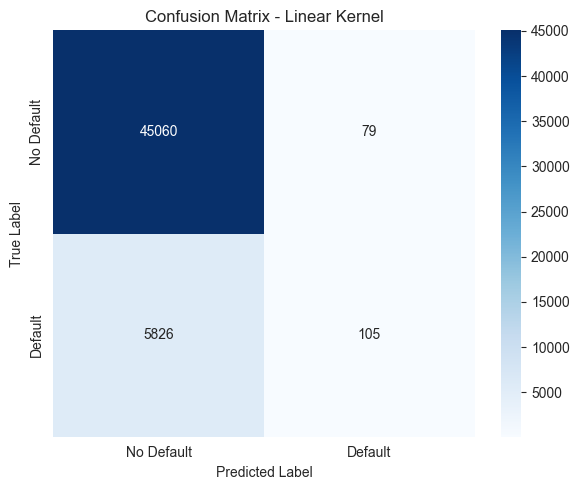

In [40]:
y_pred_2 = linear_svm.predict(X_test)
y_prob_2 = linear_svm.predict_proba(X_test)[:, 1]

# Keep test labels as numpy
y_test_np_2 = y_test.copy()

print(f"Test predictions shape: {y_pred_2.shape}")
print(f"Probability range: [{y_prob_2.min():.4f}, {y_prob_2.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np_2,
    y_pred=y_pred_2,
    y_prob=y_prob_2,
    model_name="Linear Kernel"
)

# Conclusion: pour le moment le SVM linéaire classifier a les bons résultats entre les 2 modèles

## 2. Les modèles avec justement du poids de la classe

# Modèle non linéaire avec ajustement de poids

In [41]:
start_time=time.time()



base_svm_weighted = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', gamma=3.0, n_components=100, random_state=42)),
    ('sgd', SGDClassifier(loss='hinge', class_weight='balanced', random_state=42, max_iter=1000))
])
c_svc_weighted = CalibratedClassifierCV(base_svm_weighted, method='sigmoid', cv=3)

c_svc_weighted.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds!")


✓ Training completed in 3.42 seconds!



 EVALUATION RESULTS: RBF Kernel (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    0.9998    0.9383     45139
           1     0.3077    0.0007    0.0013      5931

    accuracy                         0.8838     51070
   macro avg     0.5958    0.5002    0.4698     51070
weighted avg     0.8170    0.8838    0.8295     51070


ROC-AUC Score       : 0.6899
PR-AUC (Avg Precision) : 0.2002
Class 1 F1-Score    : 0.0013
Class 1 Recall      : 0.0007
Class 1 Precision   : 0.3077

Confusion Matrix:
[[45130     9]
 [ 5927     4]]


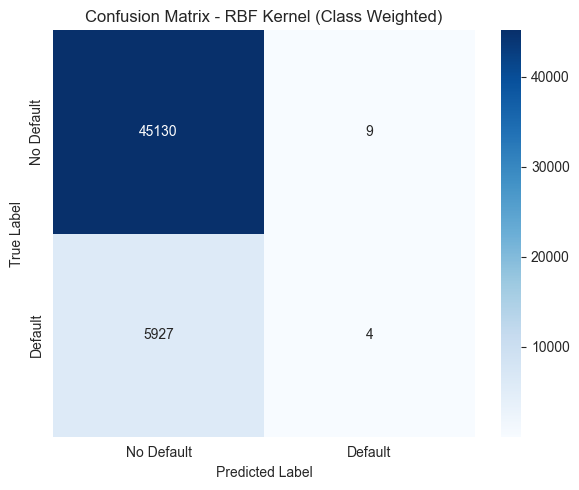

In [42]:
y_pred_weighted = c_svc_weighted.predict(X_test)
y_prob_weighted = c_svc_weighted.predict_proba(X_test)[:, 1]

# Evaluate model
evaluate_model_final(
    y_true=y_test,
    y_pred=y_pred_weighted,
    y_prob=y_prob_weighted,
    model_name="RBF Kernel (Class Weighted)"
)

## Modèle linéaire avec ajustement du poids de la classe

In [43]:


base_linear_weighted = LinearSVC(C=1.0, random_state=42, max_iter=2000, dual='auto', class_weight='balanced')
linear_svc_weighted = CalibratedClassifierCV(base_linear_weighted, method='sigmoid', cv=3)

# Train
linear_svc_weighted.fit(X_train, y_train)

# Predict (labels)
y_pred_linear_weighted = linear_svc_weighted.predict(X_test)
y_prob_linear_weighted = linear_svc_weighted.predict_proba(X_test)[:, 1]



 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.8852    0.9984    0.9384     45139
           1     0.5563    0.0150    0.0292      5931

    accuracy                         0.8842     51070
   macro avg     0.7207    0.5067    0.4838     51070
weighted avg     0.8470    0.8842    0.8328     51070


ROC-AUC Score       : 0.7394
PR-AUC (Avg Precision) : 0.2887
Class 1 F1-Score    : 0.0292
Class 1 Recall      : 0.0150
Class 1 Precision   : 0.5563

Confusion Matrix:
[[45068    71]
 [ 5842    89]]


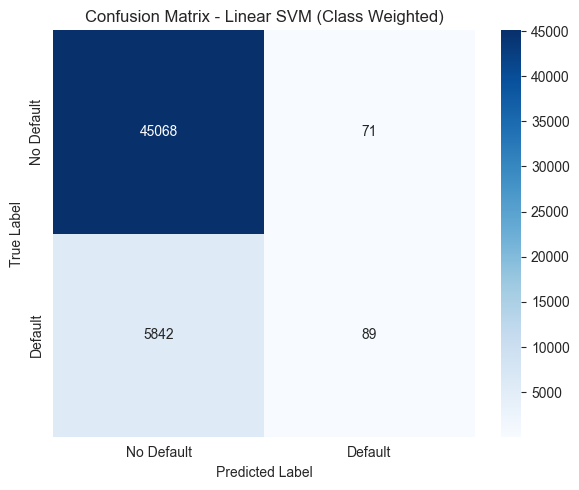

In [44]:
evaluate_model_final(
    y_true=y_test,
    y_pred=y_pred_linear_weighted,
    y_prob=y_prob_linear_weighted,
    model_name="Linear SVM (Class Weighted)"
)

# Modèle non linéaire avec SMOTE

In [ ]:
X_train_cpu = X_train.copy()
y_train_cpu = y_train.copy()

print(f"Original train shape: {X_train_cpu.shape}")
print(f"Class distribution before SMOTE:\n{pd.Series(y_train_cpu).value_counts()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_cpu, y_train_cpu)

print(f"\nAfter SMOTE:")
print(f"Resampled train shape: {X_res.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_res).value_counts()}")

Original train shape: (204277, 5)
Class distribution before SMOTE:
Default
0    180555
1     23722
Name: count, dtype: int64

After SMOTE:
Resampled train shape: (361110, 5)
Class distribution after SMOTE:
Default
0    180555
1    180555
Name: count, dtype: int64


In [ ]:
start_time = time.time()

# Non-linear SVM with RBF kernel approximation (Nystroem) - with SMOTE data
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

base_svc_smote = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', gamma='scale', n_components=100, random_state=42)),
    ('sgd', SGDClassifier(loss='hinge', random_state=42, max_iter=1000))
])
c_svc_smote = CalibratedClassifierCV(base_svc_smote, method='sigmoid', cv=3)

# Fit the model
c_svc_smote.fit(X_res, y_res)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds!")


[2025-11-06 15:32:55.704] [CUML] [warning] Random state is currently ignored by probabilistic SVC
✓ Training completed in 713.66 seconds on GPU!


Test predictions shape: (51070,)
Probability range: [0.1415, 0.8407]

 EVALUATION RESULTS: cuSVC (SMOTE )

Classification Report:
              precision    recall  f1-score   support

           0     0.9430    0.6792    0.7897     45139
           1     0.2198    0.6877    0.3331      5931

    accuracy                         0.6802     51070
   macro avg     0.5814    0.6835    0.5614     51070
weighted avg     0.8590    0.6802    0.7366     51070


ROC-AUC Score       : 0.7366
PR-AUC (Avg Precision) : 0.2740
Class 1 F1-Score    : 0.3331
Class 1 Recall      : 0.6877
Class 1 Precision   : 0.2198

Confusion Matrix:
[[30659 14480]
 [ 1852  4079]]


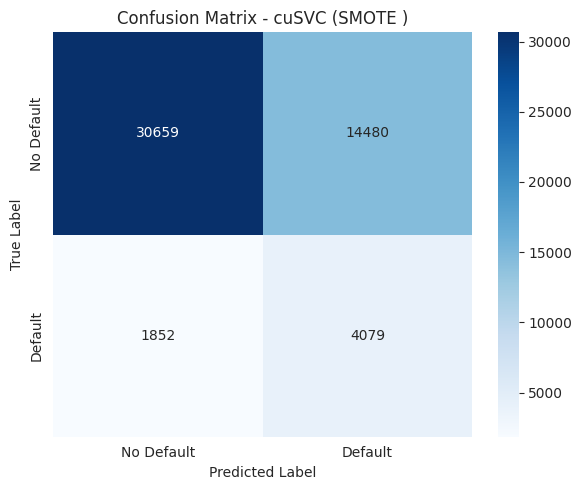

In [ ]:
y_pred_smote = c_svc_smote.predict(X_test)
y_prob_smote = c_svc_smote.predict_proba(X_test)[:, 1]

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_smote.shape}")
print(f"Probability range: [{y_prob_smote.min():.4f}, {y_prob_smote.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_smote,
    y_prob=y_prob_smote,
    model_name="SVC (SMOTE)"
)

In [ ]:
start_time = time.time()

# Use LinearSVC with Calibration for faster training (with SMOTE data)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_linear_smote = LinearSVC(C=1.0, random_state=42, max_iter=2000, dual='auto')
linear_svc_smote = CalibratedClassifierCV(base_linear_smote, method='sigmoid', cv=3)

linear_svc_smote.fit(X_res, y_res)
training_time = time.time() - start_time
print(f"✓ Linear SVM training completed in {training_time:.2f} seconds!")


✓ Linear SVM training completed in 429.65 seconds on GPU!


In [ ]:
# Predict labels
y_pred_linear_smote = linear_svc_smote.predict(X_test)
y_prob_linear_smote = linear_svc_smote.predict_proba(X_test)[:, 1]

# Test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_linear_smote.shape}")
print(f"Probability range: [{y_prob_linear_smote.min():.4f}, {y_prob_linear_smote.max():.4f}]")

Test predictions shape: (51070,)
Probability range: [0.0304, 0.9426]



 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9431    0.6618    0.7778     45139
           1     0.2129    0.6962    0.3261      5931

    accuracy                         0.6658     51070
   macro avg     0.5780    0.6790    0.5519     51070
weighted avg     0.8583    0.6658    0.7253     51070


ROC-AUC Score       : 0.7393
PR-AUC (Avg Precision) : 0.2878
Class 1 F1-Score    : 0.3261
Class 1 Recall      : 0.6962
Class 1 Precision   : 0.2129

Confusion Matrix:
[[29873 15266]
 [ 1802  4129]]


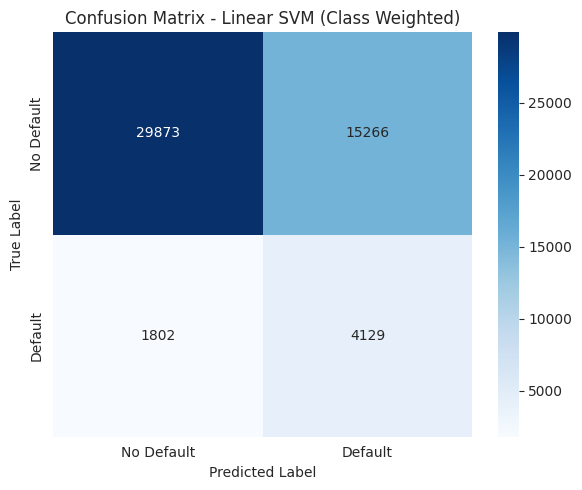

In [ ]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear_smote,
    y_prob=y_prob_linear_smote,
    model_name="Linear SVM (SMOTE)"
)

# Modèles avec sous-échantillonage

1. Modèle linéaire SVM avec sous-échantillonage


In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train, y_train)

print("Before Under-sampling:", y_train.value_counts(normalize=True) * 100)
print("After Under-sampling:", pd.Series(y_res_under).value_counts(normalize=True) * 100)

Before Under-sampling: Default
0    88.387337
1    11.612663
Name: proportion, dtype: float64
After Under-sampling: Default
0    50.0
1    50.0
Name: proportion, dtype: float64


In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Linear SVM with faster approach
start_time = time.time()
base_linear_under = LinearSVC(C=1.0, random_state=42, max_iter=2000, dual='auto')
linear_svc_under = CalibratedClassifierCV(base_linear_under, method='sigmoid', cv=3)

linear_svc_under.fit(X_res_under, y_res_under)
print(f"✓ Linear SVM trained in {time.time() - start_time:.2f} seconds")


✓ Linear SVM trained in 7.58 seconds


In [ ]:
# Prediction
y_pred_linear_under = linear_svc_under.predict(X_test)
y_prob_linear_under = linear_svc_under.predict_proba(X_test)[:, 1]


 EVALUATION RESULTS: Linear SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9432    0.6593    0.7761     45139
           1     0.2121    0.6979    0.3253      5931

    accuracy                         0.6638     51070
   macro avg     0.5776    0.6786    0.5507     51070
weighted avg     0.8583    0.6638    0.7237     51070


ROC-AUC Score       : 0.7394
PR-AUC (Avg Precision) : 0.2881
Class 1 F1-Score    : 0.3253
Class 1 Recall      : 0.6979
Class 1 Precision   : 0.2121

Confusion Matrix:
[[29760 15379]
 [ 1792  4139]]


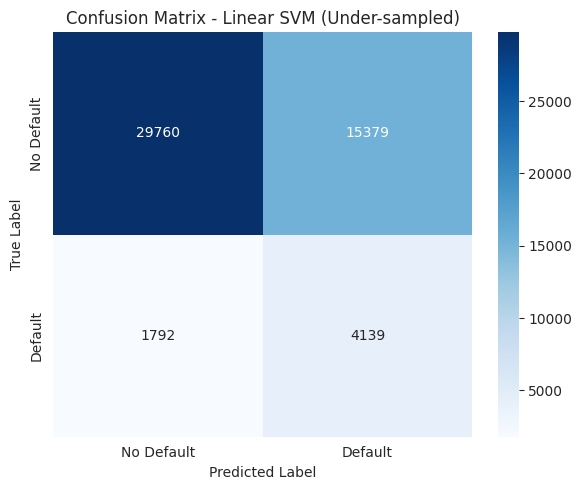

In [ ]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear_under,
    y_prob=y_prob_linear_under,
    model_name="Linear SVM (Under-sampled)"
)

2. Modèle SVM non linéaire avec sous-échantillonage

In [ ]:
# Non-linear RBF SVM with Nystroem approximation - under-sampling
start_time = time.time()

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

base_rbf_under = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', gamma='scale', n_components=100, random_state=42)),
    ('sgd', SGDClassifier(loss='hinge', random_state=42, max_iter=1000))
])
rbf_svc_under = CalibratedClassifierCV(base_rbf_under, method='sigmoid', cv=3)

rbf_svc_under.fit(X_res_under, y_res_under)
print(f"✓ RBF SVM trained in {time.time() - start_time:.2f} seconds")


✓ RBF SVM trained in 3.26 seconds



 EVALUATION RESULTS: RBF SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9434    0.6777    0.7888     45139
           1     0.2197    0.6906    0.3334      5931

    accuracy                         0.6792     51070
   macro avg     0.5816    0.6842    0.5611     51070
weighted avg     0.8594    0.6792    0.7359     51070


ROC-AUC Score       : 0.7386
PR-AUC (Avg Precision) : 0.2783
Class 1 F1-Score    : 0.3334
Class 1 Recall      : 0.6906
Class 1 Precision   : 0.2197

Confusion Matrix:
[[30592 14547]
 [ 1835  4096]]


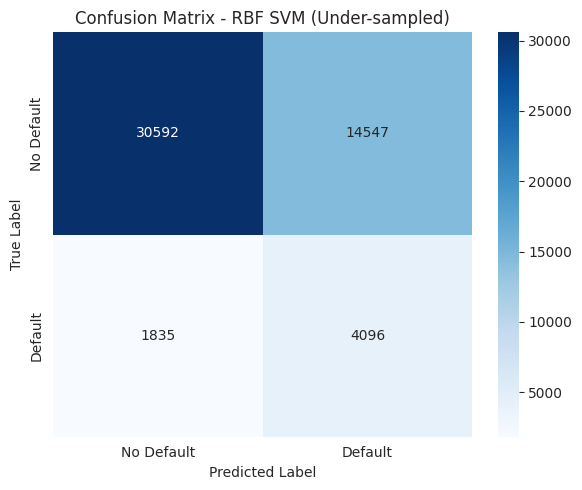

In [ ]:
# Prediction
y_pred_rbf = rbf_svc_under.predict(X_test)
y_prob_rbf = rbf_svc_under.predict_proba(X_test)[:, 1]

# Evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_rbf,
    y_prob=y_prob_rbf,
    model_name="RBF SVM (Under-sampled)"
)

# Model Comparison and Best Model Selection

In [ ]:
# Store all model results for comparison (F1-Score and Recall only)
models_comparison = []

# Helper function to safely convert to numpy
def to_numpy(arr):
    # If it's already a numpy array or pandas series, convert to numpy
    if hasattr(arr, 'to_numpy'):
        return arr.to_numpy()
    elif hasattr(arr, 'values'):
        return arr.values
    return arr

def add_model_metrics(model_name, model_obj, y_true, y_pred):
    y_true_safe = to_numpy(y_true)
    y_pred_safe = to_numpy(y_pred)
    report = classification_report(y_true_safe, y_pred_safe, digits=4, output_dict=True)
    models_comparison.append({
        'Model Name': model_name,
        'Model Object': model_obj,
        'F1-Score (Class 1)': report['1']['f1-score'],
        'Recall (Class 1)': report['1']['recall']
    })

# Model 1: C-SVC (RBF, No Balancing)
add_model_metrics('C-SVC (RBF, No Balancing)', c_svc, y_test_np, y_pred)

# Model 2: Linear SVM (No Balancing)
add_model_metrics('Linear SVM (No Balancing)', linear_svm, y_test_np_2, y_pred_2)

# Model 3: RBF with class weights
add_model_metrics('RBF SVM (Class Weighted)', c_svc_weighted, y_test, y_pred_weighted)

# Model 4: Linear SVM with class weights
add_model_metrics('Linear SVM (Class Weighted)', linear_svc_weighted, y_test, y_pred_linear_weighted)

# Model 5: RBF with SMOTE
add_model_metrics('RBF SVM (SMOTE)', c_svc_smote, y_test_np, y_pred_smote)

# Model 6: Linear SVM with SMOTE
add_model_metrics('Linear SVM (SMOTE)', linear_svc_smote, y_test_np, y_pred_linear_smote)

# Model 7: Linear SVM with under-sampling
add_model_metrics('Linear SVM (Under-sampled)', linear_svc_under, y_test_np, y_pred_linear_under)

# Model 8: RBF SVM with under-sampling
add_model_metrics('RBF SVM (Under-sampled)', rbf_svc_under, y_test_np, y_pred_rbf)

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_comparison).drop('Model Object', axis=1)

print("="*60)
print(" MODEL COMPARISON: F1-SCORE & RECALL (Class 1)")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

In [ ]:
# Visualize F1-Score and Recall comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Performance Comparison: F1-Score & Recall (Class 1)', fontsize=14, fontweight='bold')

model_names = [model['Model Name'] for model in models_comparison]

# Plot 1: F1-Score
axes[0].barh(model_names, [model['F1-Score (Class 1)'] for model in models_comparison], color='steelblue')
axes[0].set_xlabel('F1-Score (Class 1)', fontsize=11)
axes[0].set_title('F1-Score Comparison', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Recall
axes[1].barh(model_names, [model['Recall (Class 1)'] for model in models_comparison], color='coral')
axes[1].set_xlabel('Recall (Class 1)', fontsize=11)
axes[1].set_title('Recall Comparison', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Select best model based on F1-Score and Recall
print("\n" + "="*60)
print(" BEST MODEL SELECTION")
print("="*60)

# Calculate composite score (50% F1-Score, 50% Recall)
for model in models_comparison:
    model['Composite Score'] = (model['F1-Score (Class 1)'] * 0.5 + 
                                 model['Recall (Class 1)'] * 0.5)

# Find best model
best_model_idx = max(range(len(models_comparison)), key=lambda i: models_comparison[i]['Composite Score'])
best_model = models_comparison[best_model_idx]

# Display ranked models
comparison_ranked = pd.DataFrame(models_comparison).drop('Model Object', axis=1)
comparison_ranked = comparison_ranked.sort_values('Composite Score', ascending=False)

print("\n" + "="*60)
print(" ALL MODELS RANKED BY COMPOSITE SCORE")
print("="*60)
print(comparison_ranked.to_string(index=False))
print("="*60)

print("\n" + "="*60)
print(" BEST MODEL")
print("="*60)
print(f"Model Name:          {best_model['Model Name']}")
print(f"Composite Score:     {best_model['Composite Score']:.4f}")
print(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}")
print(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}")
print("="*60)

In [ ]:
# Save the best model
import pickle
import os

# Create Models directory
models_dir = './Models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
best_model_object = best_model['Model Object']
best_model_name = best_model['Model Name'].replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
model_filename = f'{models_dir}/best_svm_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_model_object, f)

# Save metadata and summary
metadata = {
    'model_name': best_model['Model Name'],
    'composite_score': best_model['Composite Score'],
    'f1_score': best_model['F1-Score (Class 1)'],
    'recall': best_model['Recall (Class 1)'],
    'saved_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_filename = f'{models_dir}/best_svm_model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)

# Save summary report
summary_filename = f'{models_dir}/model_comparison_summary.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write(" SVM MODELS COMPARISON (F1-Score & Recall)\n")
    f.write("="*60 + "\n\n")
    f.write(comparison_ranked.to_string(index=False))
    f.write("\n\n" + "="*60 + "\n")
    f.write(" BEST MODEL\n")
    f.write("="*60 + "\n")
    f.write(f"Model Name:          {best_model['Model Name']}\n")
    f.write(f"Composite Score:     {best_model['Composite Score']:.4f}\n")
    f.write(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}\n")
    f.write(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}\n")
    f.write(f"Saved Date:          {metadata['saved_date']}\n")
    f.write("="*60 + "\n")

print("\n" + "="*60)
print(" FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"Model:    {model_filename}")
print(f"Metadata: {metadata_filename}")
print(f"Summary:  {summary_filename}")
print("="*60)

# Show where files are actually saved
print(f"\nAbsolute paths:")
print(f"Models directory: {os.path.abspath(models_dir)}")